In [1]:
from platform import python_version
print(python_version())

3.6.0


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import os, audioread, pretty_midi, librosa, numpy as np
import util
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import defaultdict
from IPython.display import Audio as play
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import copy

In [78]:
all_wav_files = shuffle(librosa.util.find_files('/data/jrgillick/projects/assisted_orchestration/TinySOL/TinySOL'))
len(all_wav_files)

1532

<h3> Explore some basic stats of the audio files </h3>

In [45]:
file_stats = []
for wav in tqdm(all_wav_files):
    with audioread.audio_open(wav) as f:
        file_stats.append([f.channels, f.samplerate, f.duration])

100%|██████████| 1532/1532 [00:10<00:00, 143.35it/s]


In [46]:
# Check number of channels (all should be mono) and sample rate
set([fs[0] for fs in file_stats]), set([fs[1] for fs in file_stats])

({1}, {44100})

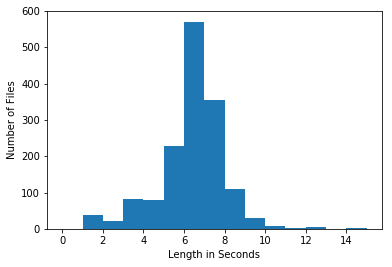

In [47]:
# plot the durations of the audio files
plt.ylabel('Number of Files')
plt.xlabel('Length in Seconds')
_ = plt.hist([fs[2] for fs in file_stats], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

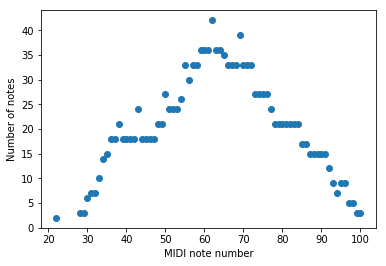

In [48]:
# check the pitches in the dataset

def get_tiny_sol_note_name(filename):
    return filename.split('/')[-1].split('-')[2]

# pull out the note name from the file string
def get_midi_pitch(filename):
    note_name = get_tiny_sol_note_name(filename)
    return(pretty_midi.note_name_to_number(note_name))

pitches = defaultdict(int)
for f in all_wav_files:
    pitches[get_midi_pitch(f)] += 1

plt.ylabel('Number of notes')
plt.xlabel('MIDI note number')
plt.scatter(pitches.keys(), pitches.values())

<h3> Compute some features - MFCC, FFT, etc.</h3>

In [49]:
# Methods to split out files by instrument, pitch, etc.

def get_instrument_type(filename):
    return filename.split('/')[-3]

def get_instrument(filename):
    return '/'.join(filename.split('/')[-3:-1])

def get_pitch_class(filename):
    return get_tiny_sol_note_name(filename)[0].lower()

def get_octave(filename):
    return get_tiny_sol_note_name(filename)[1].lower()

In [79]:
# Just grab the first 2 seconds of each file?
# Nope, take the whole thing
max_duration = 200

f1 = all_wav_files[0]
f2 = all_wav_files[1]
y1, sr = librosa.load(f1, duration=max_duration)
y2, sr = librosa.load(f2, duration=max_duration)

mfcc1 = librosa.feature.mfcc(y1, n_mfcc=20)[1:]
mfcc2 = librosa.feature.mfcc(y2, n_mfcc=20)[1:]

fft1 = np.real(librosa.stft(y1))
fft2 = np.real(librosa.stft(y2))

mel_spec1 = librosa.feature.melspectrogram(y1)
mel_spec2 = librosa.feature.melspectrogram(y2)

mfcc1.shape, fft1.shape, mel_spec1.shape

((19, 232), (1025, 232), (128, 232))

In [57]:
s = np.ones(10)
s = librosa.util.fix_length(s, 15)
s

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [118]:
#def mix_2_sounds(s1, s2, coef1, coef2):
#    return coef1*s1 + coef2*s2


def mix_n_sounds(sounds, coefs=None):
    if len(sounds) != len(coefs):
        raise("Need same # of sounds and mixture coefs")
        
    # Zero pad up to length of the longest file
    l = max([len(s) for s in sounds])
    sounds = [librosa.util.fix_length(s, l) for s in sounds]
    
    # if mixing coefficients are given, weight the sounds by those coefs
    if coefs is not None:
        weighted_sounds = [sounds[i]*coefs[i] for i in range(len(sounds))]
    
    # don't normalize, just divide by N
    return np.sum(weighted_sounds, axis=0)/len(sounds) 

#play(mix_2_sounds(y1, y2, 0.3, 0.8), rate = sr)
play(mix_n_sounds([y1, y2], [0.3, 0.8]), rate=sr)

In [225]:
S1, phase1 = librosa.magphase(librosa.stft(y1))
S15, phase15 = librosa.magphase(librosa.stft(y1/2.))
S2, phase2 = librosa.magphase(librosa.stft(y2))

In [226]:
mean_squared_feature_distance(S1,S15), mean_squared_feature_distance(S1,S2)

(38.442637195121954, 166.06231707317073)

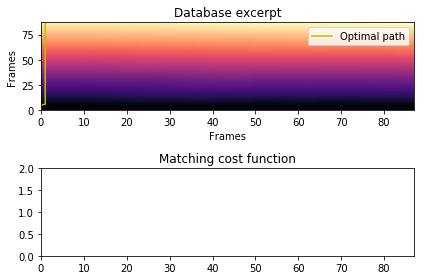

In [229]:
#y, sr = librosa.load(librosa.util.example_audio_file(), offset=10, duration=15)
#X = librosa.feature.chroma_cens(y=y, sr=sr)
#noise = np.random.rand(X.shape[0], 200)
#Y = np.concatenate((noise, noise, X, noise), axis=1)
X = S1
Y = S2
D, wp = librosa.sequence.dtw(X, Y, subseq=True)
plt.subplot(2, 1, 1)
librosa.display.specshow(D, x_axis='frames', y_axis='frames')
plt.title('Database excerpt')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(D[-1, :] / wp.shape[0])
plt.xlim([0, Y.shape[1]])
plt.ylim([0, 2])
plt.title('Matching cost function')
plt.tight_layout()

In [302]:
specs = []
spec_pairs_half = []
spec_pairs_small = []

"""
for i in tqdm(range(400)):
    S, _ = librosa.magphase(librosa.stft(train_signals[i]))
    specs.append(S)  
    
    S_half, _ = librosa.magphase(librosa.stft(train_signals[i]/2))
    S_small, _ = librosa.magphase(librosa.stft(train_signals[i]/32))
    spec_pairs_half.append([S, S_half])
    spec_pairs_small.append([S, S_small])
"""

for i in tqdm(range(400)):
    S = energy_weighted_fft(train_signals[i])
    specs.append(S)  
    
    S_half = energy_weighted_fft(train_signals[i]/2)
    S_small = energy_weighted_fft(train_signals[i]/32)
    
    spec_pairs_half.append([S, S_half])
    spec_pairs_small.append([S, S_small])

100%|██████████| 400/400 [00:09<00:00, 42.35it/s]


In [303]:
dists = []
for i in range(5000):
    indices = np.random.choice(100, 2, replace=False)
    sig1 = specs[indices[0]]
    sig2 = specs[indices[1]]
    dists.append(mean_squared_feature_distance(sig1,sig2))

In [305]:
dists_half = [mean_squared_feature_distance(p[0], p[1]) for p in spec_pairs_half]
dists_small = [mean_squared_feature_distance(p[0], p[1]) for p in spec_pairs_small]

In [177]:
def mean_squared_feature_distance(actual, forecast):
    return np.sum(np.abs ((actual - forecast) / actual)) / len (actual)

In [71]:
def real_stft(y):
    S, phase = librosa.magphase(librosa.stft(y))
    return S

def energy_weighted_fft(y):
    #S, phase = librosa.magphase(librosa.stft(y))
    #rms = librosa.feature.rmse(S=S)
    #return librosa.util.normalize(np.mean(S*rms, axis=1))
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rmse(S=S)
    return np.sum(S*rms, axis=1)/np.sum(rms)
    
def energy_weighted_mfcc(y):
    #S, phase = librosa.magphase(librosa.stft(y))
    #rms = librosa.feature.rmse(S=S)
    #mfcc = librosa.feature.mfcc(y, n_mfcc=20)[1:]
    #return librosa.util.normalize(np.mean(mfcc*rms, axis=1))
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rmse(S=S)
    mfcc = librosa.feature.mfcc(y, n_mfcc=20)[1:]
    return np.sum(mfcc*rms, axis=1)/np.sum(rms)

In [88]:
f = energy_weighted_mfcc(y2)

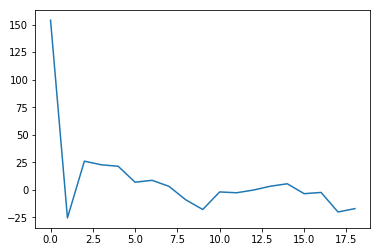

In [90]:
plt.plot(f)

<h3> Data Version 1. Make training splits across all files, meaning don't partition by different instruments or pitches </h3>

In [103]:
split_1 = int(0.6 * len(all_wav_files))
split_2 = int(0.8 * len(all_wav_files))

train_files = np.array(all_wav_files[0:split_1])
dev_files = np.array(all_wav_files[split_1:split_2])
test_files = np.array(all_wav_files[split_2:])

In [272]:
# load in a list of wav files, cropping to max_duration
def get_all_signals(files):
    signals = []
    for f in tqdm(files):
        y, sr = librosa.load(f)
        signals.append(y)
    return signals

# Compute STFT and keep the magnitudes for a list of signals
def get_all_specs(signals):
    return [real_stft(signal) for signal in tqdm(signals)]

def get_all_weighted_ffts(signals):
    return [energy_weighted_fft(signal) for signal in tqdm(signals)]

def get_all_weighted_mfccs(signals):
    return [energy_weighted_mfcc(signal) for signal in tqdm(signals)]

def get_file_rms(signal):
    return np.sqrt(np.dot(signal, signal))/len(signal)

def get_all_energies(signals):
    return [get_file_rms(signal) for signal in tqdm(signals)]

In [106]:
train_signals = get_all_signals(train_files)
dev_signals = get_all_signals(dev_files)
test_signals = get_all_signals(test_files)

100%|██████████| 307/307 [01:05<00:00,  5.37it/s]


In [155]:
train_signals = np.array(train_signals)
dev_signals = np.array(dev_signals)
test_signals = np.array(test_signals)

len(train_signals), len(dev_signals), len(test_signals)

(919, 306, 307)

In [273]:
train_energies = get_all_energies(train_signals)
dev_energies = get_all_energies(dev_signals)
test_energies = get_all_energies(test_signals)




  0%|          | 0/919 [00:00<?, ?it/s]


100%|██████████| 919/919 [00:00<00:00, 11274.98it/s]


  0%|          | 0/306 [00:00<?, ?it/s]


100%|██████████| 306/306 [00:00<00:00, 12488.51it/s]


  0%|          | 0/307 [00:00<?, ?it/s]


100%|██████████| 307/307 [00:00<00:00, 13157.29it/s]

In [116]:
train_weighted_ffts = get_all_weighted_ffts(train_signals)
dev_weighted_ffts = get_all_weighted_ffts(dev_signals)
test_weighted_ffts = get_all_weighted_ffts(test_signals)

100%|██████████| 307/307 [00:07<00:00, 43.62it/s]


In [117]:
train_weighted_mfccs = get_all_weighted_mfccs(train_signals)
dev_weighted_mfccs = get_all_weighted_mfccs(dev_signals)
test_weighted_mfccs = get_all_weighted_mfccs(test_signals)

100%|██████████| 307/307 [00:12<00:00, 25.68it/s]


In [293]:
train_weighted_ffts_scaled = copy.deepcopy(train_weighted_ffts)
dev_weighted_ffts_scaled = copy.deepcopy(dev_weighted_ffts)
test_weighted_ffts_scaled = copy.deepcopy(test_weighted_ffts)

fft_scaler = StandardScaler()
fft_scaler.fit(train_weighted_ffts_scaled)
train_weighted_ffts_scaled = fft_scaler.transform(train_weighted_ffts_scaled)
dev_weighted_ffts_scaled = fft_scaler.transform(dev_weighted_ffts_scaled)
test_weighted_ffts_scaled = fft_scaler.transform(test_weighted_ffts_scaled)

In [294]:
train_weighted_mfccs_scaled = copy.deepcopy(train_weighted_mfccs)
dev_weighted_mfccs_scaled = copy.deepcopy(dev_weighted_mfccs)
test_weighted_mfccs_scaled = copy.deepcopy(test_weighted_mfccs)

mfcc_scaler = StandardScaler()
mfcc_scaler.fit(train_weighted_mfccs_scaled)
train_weighted_mfccs_scaled = mfcc_scaler.transform(train_weighted_mfccs_scaled)
dev_weighted_mfccs_scaled = mfcc_scaler.transform(dev_weighted_mfccs_scaled)
test_weighted_mfccs_scaled = mfcc_scaler.transform(test_weighted_mfccs_scaled)

In [119]:
def make_mixes(source_signals, n_components, n_files, equal_weights = True):
    mixes = []
    components = []
    mixture_coefs = []
    for i in tqdm(range(n_files)):
        file_indices = np.random.choice(len(source_signals), n_components, replace=False)
        component_signals = source_signals[file_indices]
        if equal_weights:
            mixture_weights = np.ones(n_components)
        else:
            mixture_weights = np.random.uniform(0,1,n_components)
        mix = mix_n_sounds(component_signals, mixture_weights)

        
        mixes.append(mix)
        components.append(file_indices)
        mixture_coefs.append(mixture_weights)
    
    return mixes, components, mixture_coefs

In [120]:
train_2_mixes, components, mixture_coefs = make_mixes(train_signals, 2, 100)

100%|██████████| 100/100 [00:00<00:00, 643.38it/s]


In [121]:
play(train_2_mixes[10],rate=sr)

In [269]:
comps = components[10]
l = max(len(train_signals[comps[0]]), len(train_signals[comps[1]]))
play([librosa.util.fix_length(train_signals[comps[0]],l),librosa.util.fix_length(train_signals[comps[1]], l)], rate=sr)

<h3> FFT/MFCC Experiments - Baseline </h3>
<h4> Here we want to predict the FFT of the mixture from the component FFT's. Since FFT is linear, the hypothesis is that as we increase the number of components, the error should be roughly linear </h4>

Steps:
<ol>
    <li> Create datasets with mixtures for 2,3,5,8,10,20 components </li>
    <li> Compute the "True" error for each number of components </li>
    <li> Train separate Feed-Forward models for each number of components </li>
    <li> Compare predicted errors to true errors and make plots </li>
    <li> (Later) - Train RNN to do the predictions so we only need one model </li>
    <li> (Later 2) - Replace the Fully Connected network with a CNN </li>
    <li> (Later 3) - Replace the model inputs with learned representations to avoid the averaging step </li>
</ol>

<h4> Step 1 </h4>
Create datasets with mixtures for 2,3,5,8,10,20 components. 10K examples per dataset for starters.

In [134]:
mixture_values = [2,3,5,8,10,15,20,27,35,40,50]
num_train_datapoints = 10000
num_dev_datapoints = 2000
num_test_data_points = 2000

train_mixture_datasets = defaultdict(None)
dev_mixture_datasets = defaultdict(None)
test_mixture_datasets = defaultdict(None)

In [136]:
for m in mixture_values:
    # Train
    mixes, components, mixture_coefs = make_mixes(train_signals, m, num_train_datapoints)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    train_mixture_datasets[m] = h
    
    # Dev
    mixes, components, mixture_coefs = make_mixes(dev_signals, m, num_dev_datapoints)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    dev_mixture_datasets[m] = h

    # Test
    mixes, components, mixture_coefs = make_mixes(test_signals, m, num_test_data_points)
    h = {'mixes': mixes, 'components': components, 'mixture_coefs': mixture_coefs}
    test_mixture_datasets[m] = h


  7%|▋         | 705/10000 [00:02<00:31, 297.96it/s]


 41%|████▏     | 827/2000 [00:02<00:03, 335.10it/s]


 34%|███▍      | 3397/10000 [00:18<00:32, 200.87it/s]


 94%|█████████▍| 9418/10000 [00:48<00:02, 198.79it/s]


  5%|▍         | 456/10000 [00:04<01:34, 101.09it/s]


 38%|███▊      | 3750/10000 [00:35<00:56, 110.59it/s]


 71%|███████▏  | 7125/10000 [01:05<00:26, 109.64it/s]


 22%|██▏       | 448/2000 [00:04<00:16, 91.59it/s]


 75%|███████▌  | 1507/2000 [00:15<00:04, 100.94it/s]


 15%|█▍        | 1475/10000 [00:19<01:50, 76.88it/s]Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f3cbf3a2d68>>
Traceback (most recent call last):
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/home/jrgillick/.pyenv/versions/3.6.0/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified

 19%|█▉        | 1943/10000 [00:26<01:48, 74.39it/s]


 41%|████      | 4053/10000 [00:58<01:40, 59.19it/s]


 61%|██████    | 6096/10000 [01:31<01:02, 62.91it/s]


 81%|████████▏ | 8148/10000 [02:03<00:28, 64.30it/s]


 13%|█▎        | 260/2000 [00:03<00:26, 65.89it/s]


 18%|█▊        | 366/2000 [00:05<00:25, 65.21it/s]


  3%|▎         | 260/10000 [00:08<05:02, 32.24it/s]


 14%|█▍        | 1436/10000 [00:43<04:11, 34.04it/s]


 26%|██▌       | 2606/10000 [01:16<03:39, 33.66it/s]


 38%|███▊      | 3786/10000 [01:49<02:58, 34.86it/s]


 50%|████▉     | 4998/10000 [02:22<02:16, 36.74it/s]


 62%|██████▏   | 6211/10000 [02:54<01:58, 31.97it/s]


 74%|███████▍  | 7386/10000 [03:27<01:10, 37.34it/s]


 86%|████████▌ | 8582/10000 [04:00<00:37, 37.53it/s]


 98%|█████████▊| 9783/10000 [04:32<00:05, 36.20it/s]


 51%|█████     | 1011/2000 [00:28<00:27, 35.51it/s]


 11%|█         | 214/2000 [00:05<00:47, 37.21it/s]


 74%|███████▎  | 1474/2000 [00:39<00:13, 37.84it/s]


100%|██████████| 2000/2000 [00:53<00:00, 37.47it/s]

<h4> Step 2 </h4>
Compute the "True" error for each number of components

In [ ]:
# Compute the mixture FFT's for all datasets
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mix_ffts'] = get_all_weighted_ffts(data[m]['mixes'])


 11%|█         | 1080/10000 [00:36<05:05, 29.20it/s]


 22%|██▏       | 2201/10000 [01:14<04:18, 30.14it/s]


 33%|███▎      | 3339/10000 [01:51<03:26, 32.33it/s]


 44%|████▍     | 4447/10000 [02:28<03:10, 29.15it/s]


 56%|█████▌    | 5559/10000 [03:05<02:26, 30.27it/s]


 67%|██████▋   | 6692/10000 [03:42<01:49, 30.26it/s]


 78%|███████▊  | 7822/10000 [04:19<01:08, 31.59it/s]


 90%|████████▉ | 8956/10000 [04:56<00:46, 22.56it/s]


  1%|          | 71/10000 [00:02<05:47, 28.61it/s]


 11%|█         | 1103/10000 [00:38<05:09, 28.70it/s]


 21%|██        | 2099/10000 [01:12<04:31, 29.15it/s]


 31%|███       | 3100/10000 [01:47<04:11, 27.45it/s]


 41%|████      | 4112/10000 [02:22<03:22, 29.10it/s]


 51%|█████     | 5103/10000 [02:56<02:50, 28.72it/s]


 61%|██████    | 6079/10000 [03:30<02:14, 29.13it/s]


 70%|███████   | 7031/10000 [04:04<01:38, 30.00it/s]


 80%|████████  | 8026/10000 [04:38<01:08, 28.86it/s]


 90%|█████████ | 9022/10000 [05:13<00:34, 28.58it/s]


  0%|          | 22/10000 [00:00<06:14, 26.61it/s]


  9%|▉         | 943/10000 [00:34<05:42, 26.47it/s]


 19%|█▊        | 1852/10000 [01:07<04:43, 28.74it/s]


 27%|██▋       | 2749/10000 [01:40<04:22, 27.60it/s]


 37%|███▋      | 3660/10000 [02:13<04:26, 23.79it/s]


 46%|████▌     | 4569/10000 [02:47<03:06, 29.18it/s]


 55%|█████▍    | 5462/10000 [03:20<02:52, 26.35it/s]


 63%|██████▎   | 6345/10000 [03:54<02:19, 26.18it/s]


 72%|███████▏  | 7239/10000 [04:28<01:44, 26.50it/s]


 81%|████████▏ | 8126/10000 [05:02<01:13, 25.49it/s]


 90%|█████████ | 9023/10000 [05:35<00:37, 26.34it/s]


 99%|█████████▉| 9930/10000 [06:08<00:02, 27.99it/s]


  8%|▊         | 825/10000 [00:31<06:11, 24.72it/s]


 17%|█▋        | 1710/10000 [01:05<05:38, 24.52it/s]


 26%|██▌       | 2588/10000 [01:38<04:42, 26.28it/s]


 35%|███▍      | 3471/10000 [02:12<04:12, 25.86it/s]


 43%|████▎     | 4349/10000 [02:45<03:30, 26.87it/s]


 52%|█████▏    | 5226/10000 [03:19<03:07, 25.44it/s]


 61%|██████    | 6105/10000 [03:54<02:29, 26.02it/s]


 70%|██████▉   | 6982/10000 [04:28<02:01, 24.82it/s]


 79%|███████▊  | 7862/10000 [05:02<01:22, 25.77it/s]


 87%|████████▋ | 8739/10000 [05:36<00:51, 24.56it/s]


 96%|█████████▌| 9616/10000 [06:11<00:14, 25.86it/s]


  5%|▌         | 501/10000 [00:19<06:07, 25.83it/s]


 14%|█▍        | 1384/10000 [00:54<06:01, 23.82it/s]


 23%|██▎       | 2260/10000 [01:29<05:26, 23.74it/s]


 31%|███▏      | 3136/10000 [02:04<04:17, 26.69it/s]


 40%|████      | 4012/10000 [02:38<03:54, 25.51it/s]


 49%|████▉     | 4890/10000 [03:12<03:27, 24.66it/s]


 58%|█████▊    | 5767/10000 [03:46<02:39, 26.61it/s]


 66%|██████▋   | 6643/10000 [04:20<02:19, 24.13it/s]


 75%|███████▌  | 7520/10000 [04:55<01:39, 24.86it/s]


 84%|████████▍ | 8397/10000 [05:29<00:59, 26.97it/s]


 93%|█████████▎| 9273/10000 [06:03<00:28, 25.66it/s]


  2%|▏         | 150/10000 [00:06<06:53, 23.82it/s]


 10%|█         | 1038/10000 [00:42<06:10, 24.17it/s]


 19%|█▉        | 1914/10000 [01:19<05:50, 23.09it/s]


 28%|██▊       | 2785/10000 [01:55<04:57, 24.21it/s]


 37%|███▋      | 3661/10000 [02:32<04:11, 25.20it/s]


 45%|████▌     | 4537/10000 [03:07<03:37, 25.10it/s]


 54%|█████▍    | 5413/10000 [03:43<03:07, 24.50it/s]


 63%|██████▎   | 6289/10000 [04:20<02:35, 23.83it/s]


 72%|███████▏  | 7165/10000 [04:57<01:59, 23.72it/s]


 80%|████████  | 8041/10000 [05:34<01:17, 25.23it/s]


 89%|████████▉ | 8917/10000 [06:11<00:45, 23.73it/s]


 98%|█████████▊| 9793/10000 [06:48<00:08, 24.28it/s]


 44%|████▍     | 889/2000 [00:29<00:36, 30.18it/s]


  1%|▏         | 29/2000 [00:00<01:05, 29.91it/s]


 54%|█████▍    | 1075/2000 [00:36<00:33, 27.83it/s]


  4%|▎         | 74/2000 [00:02<01:08, 27.95it/s]


 51%|█████     | 1019/2000 [00:36<00:34, 28.55it/s]


 97%|█████████▋| 1936/2000 [01:10<00:02, 26.26it/s]


 42%|████▏     | 845/2000 [00:32<00:42, 27.33it/s]


 87%|████████▋ | 1740/2000 [01:05<00:10, 24.84it/s]


 32%|███▏      | 639/2000 [00:24<00:55, 24.68it/s]


 77%|███████▋  | 1537/2000 [00:59<00:18, 25.69it/s]


 22%|██▏       | 435/2000 [00:17<01:01, 25.28it/s]


 67%|██████▋   | 1335/2000 [00:53<00:27, 24.56it/s]


 14%|█▍        | 284/2000 [00:09<00:57, 29.59it/s]


 73%|███████▎  | 1456/2000 [00:47<00:17, 31.23it/s]


 30%|██▉       | 598/2000 [00:19<00:45, 30.78it/s]


 84%|████████▍ | 1689/2000 [00:56<00:10, 30.03it/s]


 35%|███▌      | 708/2000 [00:24<00:44, 28.76it/s]


 83%|████████▎ | 1661/2000 [00:58<00:11, 28.83it/s]


 17%|█▋        | 349/2000 [00:13<00:59, 27.74it/s]

In [ ]:
# Compute the mixture MFCC's for all datasets
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mix_mfccs'] = get_all_weighted_mfccs(data[m]['mixes'])

In [151]:
# Compute the mean mixture FFT's and MFCC's for all datasets to use as a baseline
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        data[m]['mean_fft'] = np.mean(data[m]['mix_ffts'], axis=0)
        data[m]['mean_mfcc'] = np.mean(data[m]['mix_mfccs'], axis=0)

In [ ]:
# scale the mixture features per dataset
for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
    for m in mixture_values:
        scaled_mix_ffts = copy.deepcopy(data[m]['mix_mfccs'])
        

array([7.2947363e-03, 6.4186701e-03, 2.4174564e-03, ..., 1.1899697e-09,
       7.2222883e-10, 4.2338510e-10], dtype=float32)

In [ ]:
_ = """
train_2 = train_mixture_datasets[2]
dev_2 = dev_mixture_datasets[2]
test_2 = test_mixture_datasets[2]

train_mix_weighted_ffts = [energy_weighted_fft(train_2['mixes'][i]) for i in tqdm(range(len(train_2['mixes'])))]
dev_mix_weighted_ffts = [energy_weighted_fft(dev_2['mixes'][i]) for i in tqdm(range(len(dev_2['mixes'])))]
test_mix_weighted_ffts = [energy_weighted_fft(test_2['mixes'][i]) for i in tqdm(range(len(test_2['mixes'])))]

play(train_2['mixes'][0], rate=sr)
play(train_signals[train_2['components'][0][0:2]], rate=sr)
"""

In [244]:
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
import keras.optimizers

def mfcc_to_mfcc_model(n_components):
    model = Sequential()
    model.add(Dense(100, use_bias=True,input_dim=19*n_components))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(19, use_bias=True))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
    return model

def get_mfcc_mix_targets(dataset):
    return np.array(dataset['mix_mfccs'])

def get_mfcc_inputs(dataset, source_mfccs, flatten=True):
    datapoints = []
    component_lists = dataset['components']
    for component_indices in component_lists:
        mfcc_vectors = np.vstack([source_mfccs[i] for i in component_indices])
        if flatten:
            mfcc_vectors = mfcc_vectors.reshape(-1)
        datapoints.append(mfcc_vectors)
    return np.array(datapoints)

def fft_to_fft_model(n_components):
    model = Sequential()
    model.add(Dense(100, use_bias=True,input_dim=1025*n_components))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(1025, use_bias=True))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
    return model

def get_fft_mix_targets(dataset):
    return np.array(dataset['mix_ffts'])

def get_fft_inputs(dataset, source_ffts, flatten=True):
    datapoints = []
    component_lists = dataset['components']
    for component_indices in component_lists:
        fft_vectors = np.vstack([source_ffts[i] for i in component_indices])
        if flatten:
            fft_vectors = fft_vectors.reshape(-1)
        datapoints.append(fft_vectors)
    return np.array(datapoints)

In [245]:
#dev_weighted_ffts = copy.deepcopy(test_weighted_ffts)
#dev_weighted_mfccs = copy.deepcopy(test_weighted_mfccs)
#dev_energies = copy.deepcopy(test_energies)

In [249]:
# Train models to predict MFCC from MFCC

mlp_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    mlp_models[m] = mfcc_to_mfcc_model(m)
    
    X_train = copy.deepcopy(get_mfcc_inputs(train_mixture_datasets[m], train_weighted_mfccs))
    y_train = copy.deepcopy(get_mfcc_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs))
    y_dev = copy.deepcopy(get_mfcc_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 50
    for e in tqdm(range(epochs)):
        mlp_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, verbose=False)

Training model for 2 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:24,  4.17s/it]


  4%|▍         | 2/50 [00:04<02:24,  3.01s/it]


  6%|▌         | 3/50 [00:04<01:44,  2.22s/it]


  8%|▊         | 4/50 [00:05<01:16,  1.65s/it]


 10%|█         | 5/50 [00:05<00:56,  1.26s/it]


 12%|█▏        | 6/50 [00:05<00:43,  1.02it/s]


 14%|█▍        | 7/50 [00:06<00:34,  1.26it/s]


 16%|█▌        | 8/50 [00:06<00:27,  1.51it/s]


 18%|█▊        | 9/50 [00:06<00:23,  1.76it/s]


 20%|██        | 10/50 [00:07<00:20,  2.00it/s]


 22%|██▏       | 11/50 [00:07<00:17,  2.21it/s]


 24%|██▍       | 12/50 [00:07<00:16,  2.36it/s]


 26%|██▌       | 13/50 [00:08<00:15,  2.46it/s]


 28%|██▊       | 14/50 [00:08<00:14,  2.54it/s]


 30%|███       | 15/50 [00:09<00:13,  2.67it/s]


 32%|███▏      | 16/50 [00:09<00:12,  2.76it/s]


 34%|███▍      | 17/50 [00:09<00:11,  2.84it/s]


 36%|███▌      | 18/50 [00:10<00:11,  2.88it/s]


 38%|███▊      | 19/50 [00:10<00:10,  2.85it/s]


 40%|████      

Training model for 3 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:28,  4.25s/it]


  4%|▍         | 2/50 [00:04<02:26,  3.06s/it]


  6%|▌         | 3/50 [00:04<01:45,  2.24s/it]


  8%|▊         | 4/50 [00:05<01:16,  1.67s/it]


 10%|█         | 5/50 [00:05<00:57,  1.27s/it]


 12%|█▏        | 6/50 [00:05<00:43,  1.00it/s]


 14%|█▍        | 7/50 [00:06<00:34,  1.25it/s]


 16%|█▌        | 8/50 [00:06<00:27,  1.51it/s]


 18%|█▊        | 9/50 [00:06<00:23,  1.76it/s]


 20%|██        | 10/50 [00:07<00:20,  1.98it/s]


 22%|██▏       | 11/50 [00:07<00:17,  2.19it/s]


 24%|██▍       | 12/50 [00:07<00:16,  2.35it/s]


 26%|██▌       | 13/50 [00:08<00:14,  2.50it/s]


 28%|██▊       | 14/50 [00:08<00:13,  2.60it/s]


 30%|███       | 15/50 [00:09<00:12,  2.70it/s]


 32%|███▏      | 16/50 [00:09<00:12,  2.75it/s]


 34%|███▍      | 17/50 [00:09<00:11,  2.78it/s]


 36%|███▌      | 18/50 [00:10<00:11,  2.80it/s]


 38%|███▊      | 19/50 [00:10<00:11,  2.79it/s]


 40%|████      

Training model for 5 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:34,  4.38s/it]


  4%|▍         | 2/50 [00:04<02:31,  3.16s/it]


  6%|▌         | 3/50 [00:05<01:48,  2.32s/it]


  8%|▊         | 4/50 [00:05<01:19,  1.72s/it]


 10%|█         | 5/50 [00:05<00:59,  1.32s/it]


 12%|█▏        | 6/50 [00:06<00:45,  1.04s/it]


 14%|█▍        | 7/50 [00:06<00:35,  1.20it/s]


 16%|█▌        | 8/50 [00:06<00:28,  1.45it/s]


 18%|█▊        | 9/50 [00:07<00:24,  1.69it/s]


 20%|██        | 10/50 [00:07<00:21,  1.89it/s]


 22%|██▏       | 11/50 [00:07<00:18,  2.06it/s]


 24%|██▍       | 12/50 [00:08<00:16,  2.28it/s]


 26%|██▌       | 13/50 [00:08<00:15,  2.40it/s]


 28%|██▊       | 14/50 [00:09<00:14,  2.50it/s]


 30%|███       | 15/50 [00:09<00:13,  2.59it/s]


 32%|███▏      | 16/50 [00:09<00:13,  2.61it/s]


 34%|███▍      | 17/50 [00:10<00:12,  2.63it/s]


 36%|███▌      | 18/50 [00:10<00:12,  2.62it/s]


 38%|███▊      | 19/50 [00:10<00:11,  2.68it/s]


 40%|████      

Training model for 8 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:47,  4.64s/it]


  4%|▍         | 2/50 [00:04<02:40,  3.35s/it]


  6%|▌         | 3/50 [00:05<01:55,  2.45s/it]


  8%|▊         | 4/50 [00:05<01:23,  1.82s/it]


 10%|█         | 5/50 [00:06<01:01,  1.37s/it]


 12%|█▏        | 6/50 [00:06<00:47,  1.08s/it]


 14%|█▍        | 7/50 [00:06<00:37,  1.16it/s]


 16%|█▌        | 8/50 [00:07<00:30,  1.39it/s]


 18%|█▊        | 9/50 [00:07<00:25,  1.61it/s]


 20%|██        | 10/50 [00:07<00:21,  1.84it/s]


 22%|██▏       | 11/50 [00:08<00:19,  2.05it/s]


 24%|██▍       | 12/50 [00:08<00:17,  2.18it/s]


 26%|██▌       | 13/50 [00:08<00:15,  2.34it/s]


 28%|██▊       | 14/50 [00:09<00:15,  2.40it/s]


 30%|███       | 15/50 [00:09<00:14,  2.44it/s]


 32%|███▏      | 16/50 [00:10<00:13,  2.49it/s]


 34%|███▍      | 17/50 [00:10<00:12,  2.57it/s]


 36%|███▌      | 18/50 [00:10<00:12,  2.65it/s]


 38%|███▊      | 19/50 [00:11<00:11,  2.66it/s]


 40%|████      

Training model for 10 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:49,  4.68s/it]


  4%|▍         | 2/50 [00:05<02:42,  3.39s/it]


  6%|▌         | 3/50 [00:05<01:57,  2.51s/it]


  8%|▊         | 4/50 [00:05<01:26,  1.88s/it]


 10%|█         | 5/50 [00:06<01:04,  1.43s/it]


 12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]


 14%|█▍        | 7/50 [00:07<00:38,  1.11it/s]


 16%|█▌        | 8/50 [00:07<00:31,  1.32it/s]


 18%|█▊        | 9/50 [00:07<00:26,  1.55it/s]


 20%|██        | 10/50 [00:08<00:22,  1.77it/s]


 22%|██▏       | 11/50 [00:08<00:19,  1.99it/s]


 24%|██▍       | 12/50 [00:09<00:17,  2.14it/s]


 26%|██▌       | 13/50 [00:09<00:16,  2.23it/s]


 28%|██▊       | 14/50 [00:09<00:15,  2.33it/s]


 30%|███       | 15/50 [00:10<00:14,  2.33it/s]


 32%|███▏      | 16/50 [00:10<00:14,  2.39it/s]


 34%|███▍      | 17/50 [00:11<00:13,  2.39it/s]


 36%|███▌      | 18/50 [00:11<00:13,  2.40it/s]


 38%|███▊      | 19/50 [00:11<00:12,  2.41it/s]


 40%|████      

Training model for 20 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:04<03:45,  4.60s/it]


  4%|▍         | 2/50 [00:04<02:40,  3.34s/it]


  6%|▌         | 3/50 [00:05<01:55,  2.45s/it]


  8%|▊         | 4/50 [00:05<01:24,  1.84s/it]


 10%|█         | 5/50 [00:06<01:03,  1.42s/it]


 12%|█▏        | 6/50 [00:06<00:48,  1.11s/it]


 14%|█▍        | 7/50 [00:07<00:38,  1.11it/s]


 16%|█▌        | 8/50 [00:07<00:32,  1.31it/s]


 18%|█▊        | 9/50 [00:07<00:26,  1.53it/s]


 20%|██        | 10/50 [00:08<00:23,  1.71it/s]


 22%|██▏       | 11/50 [00:08<00:20,  1.87it/s]


 24%|██▍       | 12/50 [00:09<00:19,  1.98it/s]


 26%|██▌       | 13/50 [00:09<00:17,  2.07it/s]


 28%|██▊       | 14/50 [00:09<00:16,  2.18it/s]


 30%|███       | 15/50 [00:10<00:15,  2.23it/s]


 32%|███▏      | 16/50 [00:10<00:15,  2.25it/s]


 34%|███▍      | 17/50 [00:11<00:14,  2.33it/s]


 36%|███▌      | 18/50 [00:11<00:13,  2.38it/s]


 38%|███▊      | 19/50 [00:12<00:13,  2.34it/s]


 40%|████      

In [250]:
# Train models to predict FFT from FFT

fft_mlp_models = defaultdict(None)

# Train a separate model for each number of components
for m in mixture_values:
    print("Training model for %d components" % (m))
    fft_mlp_models[m] = fft_to_fft_model(m)
    
    X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))
    
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)

    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(get_fft_mix_targets(dev_mixture_datasets[m]))
    
    #X_train = X_scaler.transform(X_train)
    #X_dev = X_scaler.transform(X_dev)
    #y_train = y_scaler.transform(y_train)
    #y_dev = y_scaler.transform(y_dev)

    epochs = 50
    for e in tqdm(range(epochs)):
        fft_mlp_models[m].fit(X_train, y_train, validation_data=[X_dev, y_dev], batch_size=200, verbose=False)

Training model for 2 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:05,  5.02s/it]


  4%|▍         | 2/50 [00:05<02:55,  3.65s/it]


  6%|▌         | 3/50 [00:05<02:06,  2.70s/it]


  8%|▊         | 4/50 [00:06<01:33,  2.03s/it]


 10%|█         | 5/50 [00:06<01:10,  1.58s/it]


 12%|█▏        | 6/50 [00:07<00:55,  1.25s/it]


 14%|█▍        | 7/50 [00:07<00:44,  1.03s/it]


 16%|█▌        | 8/50 [00:08<00:36,  1.15it/s]


 18%|█▊        | 9/50 [00:08<00:30,  1.33it/s]


 20%|██        | 10/50 [00:09<00:27,  1.47it/s]


 22%|██▏       | 11/50 [00:09<00:24,  1.59it/s]


 24%|██▍       | 12/50 [00:10<00:22,  1.70it/s]


 26%|██▌       | 13/50 [00:10<00:20,  1.78it/s]


 28%|██▊       | 14/50 [00:11<00:19,  1.85it/s]


 30%|███       | 15/50 [00:11<00:18,  1.89it/s]


 32%|███▏      | 16/50 [00:12<00:17,  1.94it/s]


 34%|███▍      | 17/50 [00:12<00:16,  1.98it/s]


 36%|███▌      | 18/50 [00:13<00:16,  2.00it/s]


 38%|███▊      | 19/50 [00:13<00:15,  2.02it/s]


 40%|████      

Training model for 3 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:15,  5.22s/it]


  4%|▍         | 2/50 [00:05<03:02,  3.80s/it]


  6%|▌         | 3/50 [00:06<02:12,  2.82s/it]


  8%|▊         | 4/50 [00:06<01:38,  2.14s/it]


 10%|█         | 5/50 [00:07<01:14,  1.66s/it]


 12%|█▏        | 6/50 [00:07<00:57,  1.31s/it]


 14%|█▍        | 7/50 [00:08<00:45,  1.06s/it]


 16%|█▌        | 8/50 [00:08<00:37,  1.11it/s]


 18%|█▊        | 9/50 [00:09<00:32,  1.28it/s]


 20%|██        | 10/50 [00:09<00:28,  1.42it/s]


 22%|██▏       | 11/50 [00:10<00:25,  1.55it/s]


 24%|██▍       | 12/50 [00:10<00:22,  1.66it/s]


 26%|██▌       | 13/50 [00:11<00:21,  1.75it/s]


 28%|██▊       | 14/50 [00:11<00:19,  1.84it/s]


 30%|███       | 15/50 [00:12<00:18,  1.89it/s]


 32%|███▏      | 16/50 [00:12<00:17,  1.91it/s]


 34%|███▍      | 17/50 [00:13<00:17,  1.94it/s]


 36%|███▌      | 18/50 [00:13<00:16,  1.95it/s]


 38%|███▊      | 19/50 [00:14<00:15,  1.98it/s]


 40%|████      

Training model for 5 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:33,  5.57s/it]


  4%|▍         | 2/50 [00:06<03:15,  4.08s/it]


  6%|▌         | 3/50 [00:06<02:22,  3.03s/it]


  8%|▊         | 4/50 [00:07<01:45,  2.29s/it]


 10%|█         | 5/50 [00:07<01:20,  1.78s/it]


 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]


 14%|█▍        | 7/50 [00:09<00:49,  1.16s/it]


 16%|█▌        | 8/50 [00:09<00:41,  1.02it/s]


 18%|█▊        | 9/50 [00:10<00:35,  1.15it/s]


 20%|██        | 10/50 [00:10<00:31,  1.28it/s]


 22%|██▏       | 11/50 [00:11<00:27,  1.41it/s]


 24%|██▍       | 12/50 [00:11<00:25,  1.50it/s]


 26%|██▌       | 13/50 [00:12<00:23,  1.60it/s]


 28%|██▊       | 14/50 [00:12<00:21,  1.70it/s]


 30%|███       | 15/50 [00:13<00:19,  1.76it/s]


 32%|███▏      | 16/50 [00:13<00:18,  1.82it/s]


 34%|███▍      | 17/50 [00:14<00:18,  1.80it/s]


 36%|███▌      | 18/50 [00:15<00:18,  1.76it/s]


 38%|███▊      | 19/50 [00:15<00:17,  1.78it/s]


 40%|████      

Training model for 8 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:31,  5.54s/it]


  4%|▍         | 2/50 [00:06<03:15,  4.07s/it]


  6%|▌         | 3/50 [00:06<02:23,  3.05s/it]


  8%|▊         | 4/50 [00:07<01:48,  2.35s/it]


 10%|█         | 5/50 [00:08<01:22,  1.84s/it]


 12%|█▏        | 6/50 [00:08<01:05,  1.50s/it]


 14%|█▍        | 7/50 [00:09<00:53,  1.25s/it]


 16%|█▌        | 8/50 [00:10<00:44,  1.06s/it]


 18%|█▊        | 9/50 [00:10<00:39,  1.04it/s]


 20%|██        | 10/50 [00:11<00:35,  1.14it/s]


 22%|██▏       | 11/50 [00:12<00:32,  1.19it/s]


 24%|██▍       | 12/50 [00:13<00:29,  1.27it/s]


 26%|██▌       | 13/50 [00:13<00:28,  1.30it/s]


 28%|██▊       | 14/50 [00:14<00:26,  1.37it/s]


 30%|███       | 15/50 [00:15<00:24,  1.41it/s]


 32%|███▏      | 16/50 [00:15<00:24,  1.40it/s]


 34%|███▍      | 17/50 [00:16<00:23,  1.40it/s]


 36%|███▌      | 18/50 [00:17<00:23,  1.39it/s]


 38%|███▊      | 19/50 [00:17<00:21,  1.41it/s]


 40%|████      

Training model for 10 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:40,  5.72s/it]


  4%|▍         | 2/50 [00:06<03:22,  4.22s/it]


  6%|▌         | 3/50 [00:07<02:29,  3.19s/it]


  8%|▊         | 4/50 [00:07<01:53,  2.46s/it]


 10%|█         | 5/50 [00:08<01:26,  1.93s/it]


 12%|█▏        | 6/50 [00:09<01:09,  1.57s/it]


 14%|█▍        | 7/50 [00:10<00:56,  1.32s/it]


 16%|█▌        | 8/50 [00:10<00:48,  1.17s/it]


 18%|█▊        | 9/50 [00:11<00:43,  1.06s/it]


 20%|██        | 10/50 [00:12<00:38,  1.04it/s]


 22%|██▏       | 11/50 [00:13<00:34,  1.13it/s]


 24%|██▍       | 12/50 [00:13<00:31,  1.20it/s]


 26%|██▌       | 13/50 [00:14<00:30,  1.22it/s]


 28%|██▊       | 14/50 [00:15<00:29,  1.23it/s]


 30%|███       | 15/50 [00:16<00:27,  1.26it/s]


 32%|███▏      | 16/50 [00:17<00:26,  1.27it/s]


 34%|███▍      | 17/50 [00:17<00:26,  1.25it/s]


 36%|███▌      | 18/50 [00:18<00:25,  1.26it/s]


 38%|███▊      | 19/50 [00:19<00:24,  1.27it/s]


 40%|████      

Training model for 20 components





  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:06<05:39,  6.94s/it]


  4%|▍         | 2/50 [00:07<04:08,  5.17s/it]


  6%|▌         | 3/50 [00:09<03:06,  3.96s/it]


  8%|▊         | 4/50 [00:10<02:23,  3.12s/it]


 10%|█         | 5/50 [00:11<01:54,  2.53s/it]


 12%|█▏        | 6/50 [00:12<01:33,  2.11s/it]


 14%|█▍        | 7/50 [00:13<01:18,  1.83s/it]


 16%|█▌        | 8/50 [00:14<01:08,  1.63s/it]


 18%|█▊        | 9/50 [00:16<01:01,  1.49s/it]


 20%|██        | 10/50 [00:17<00:55,  1.39s/it]


 22%|██▏       | 11/50 [00:18<00:52,  1.35s/it]


 24%|██▍       | 12/50 [00:19<00:49,  1.29s/it]


 26%|██▌       | 13/50 [00:20<00:46,  1.27s/it]


 28%|██▊       | 14/50 [00:22<00:44,  1.25s/it]


 30%|███       | 15/50 [00:23<00:42,  1.23s/it]


 32%|███▏      | 16/50 [00:24<00:41,  1.21s/it]


 34%|███▍      | 17/50 [00:25<00:39,  1.19s/it]


 36%|███▌      | 18/50 [00:26<00:36,  1.14s/it]


 38%|███▊      | 19/50 [00:27<00:35,  1.15s/it]


 40%|████      

In [280]:
# Takes indices into a pre-computed list of fft's and returns those fft's
def sum_component_ffts(fft_list, component_indices, energy_list=None, energy_weighted=True):
    if energy_list is not None and energy_weighted:
    # Take a weighted sum of the feature vectors, weighted by the energy of the feature vector
    # normalize by the sum of the rms   
        energies = np.array([energy_list[i] for i in component_indices])
        #ffts = np.array([fft_list[i] for i in component_indices])
        ffts = np.array([fft_list[i]*energy_list[i] for i in component_indices])
        weighted_sum = np.sum(ffts, axis=0)
        return weighted_sum / np.sum(energies)
    else:
        #Take the mean of each feature vector
        return np.mean([fft_list[i] for i in component_indices], axis=0) 

# Get a list of all the errors
def get_errors(true_mixture_ffts, predicted_ffts):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        errors.append(mean_squared_feature_distance(y_true, y_pred))
    return errors

# Compute the error as improvement relative to the baseline 
# With "baseline" meaning the average of the feature vector over all ~10K data points)
# This interpretation of the error can correct for the differences in variances of the datasets
def get_relative_errors(true_mixture_ffts, predicted_ffts, baseline_vector):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        baseline_error = mean_squared_feature_distance(y_true, baseline_vector)
        error = mean_squared_feature_distance(y_true, y_pred)
        relative_error = error/baseline_error
        errors.append(relative_error)
    return errors

# Inputs are a list of the precomputed component FFT's,
# and a list of the identities of the mixture components
def make_baseline_predictions(component_ffts, mixture_component_indices, energy_list=None):
    #preds = []
    #for i in range(len(component_ffts)):
    #    preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i]))
    #return preds
    preds = []
    for i in range(len(mixture_component_indices)):
        preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i], energy_list=energy_list))
    return preds

In [213]:
y_train_A = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[2]))

In [215]:
y_train_A.shape

(10000, 1025)

In [276]:
A_dev_mix_mfccs = dev_mixture_datasets[2]['mix_mfccs']

Mean Baseline Error:  0.06258711367131431  | Mean MLP Error:  0.7311394617445718
Mean Baseline Error:  0.11573579838929005  | Mean MLP Error:  0.8037720560258383
Mean Baseline Error:  0.2170040307385752  | Mean MLP Error:  0.7526701333630615
Mean Baseline Error:  0.3781056885692174  | Mean MLP Error:  0.8247446547990437
Mean Baseline Error:  0.4913508182521506  | Mean MLP Error:  0.8527362928684415
Mean Baseline Error:  1.0779324185899126  | Mean MLP Error:  0.9377544403630813


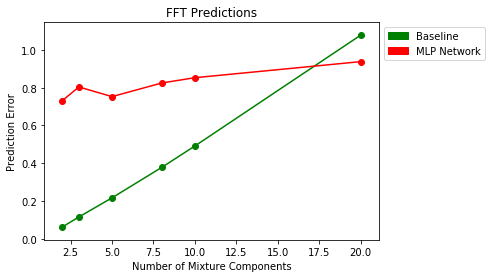

In [286]:
# Compute "True" FFT error on dev data
baseline_errors_per_dataset = []
mlp_errors_per_dataset = []

for m in mixture_values:
    dev_mix_ffts = np.array(dev_mixture_datasets[m]['mix_ffts'])
    
    #X_train = copy.deepcopy(get_fft_inputs(train_mixture_datasets[m], train_weighted_ffts))
    #y_train = copy.deepcopy(get_fft_mix_targets(train_mixture_datasets[m]))
    #X_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    
    #X_scaler.fit(X_train)
    #y_scaler.fit(y_train)
    
    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    y_dev = copy.deepcopy(dev_mix_ffts)
    #X_dev = X_scaler.transform(X_dev)
    #y_dev = y_scaler.transform(y_dev)
    
    #X_scaler_baseline = StandardScaler()
    source_fft_data = copy.deepcopy(dev_weighted_ffts)
    source_energies = copy.deepcopy(dev_energies)
    #X_scaler_baseline.fit(source_fft_data)
    #source_fft_data = X_scaler_baseline.transform(source_fft_data)
    
    baseline_predictions = make_baseline_predictions(source_fft_data, dev_mixture_datasets[m]['components'], energy_list = source_energies)
    dev_mixture_datasets[m]['baseline_predicted_mix_ffts'] = baseline_predictions
    
    #baseline_errors = get_errors(y_dev, baseline_predictions)
    baseline_errors = get_relative_errors(dev_mix_ffts, baseline_predictions, dev_mixture_datasets[m]['mean_fft'])
    baseline_errors_per_dataset.append(baseline_errors)
    

    
    mlp_predictions = fft_mlp_models[m].predict(X_dev, batch_size=200)    
    #mlp_errors = get_errors(y_dev, mlp_predictions)
    mlp_errors = get_relative_errors(dev_mix_ffts, mlp_predictions, dev_mixture_datasets[m]['mean_fft'])
    mlp_errors_per_dataset.append(mlp_errors)
    
    print("Mean Baseline Error: ", np.mean(baseline_errors), " | Mean MLP Error: ", np.mean(mlp_errors))
    #_ = plt.hist(errors, bins=50)
    
plt.title("FFT Predictions")
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error")

_ = plt.plot(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'g')
_ = plt.scatter(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'g')

_ = plt.plot(mixture_values, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(mixture_values, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

handles = [mpatches.Patch(color='g',label='Baseline'),
           mpatches.Patch(color='r',label='MLP Network')]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

Mean Baseline Error:  0.8854207593493184  | Mean MLP Error:  0.8419658069725585
Mean Baseline Error:  0.9576844260440861  | Mean MLP Error:  0.8492016551494571
Mean Baseline Error:  0.9432321262523877  | Mean MLP Error:  0.8622255410130694
Mean Baseline Error:  0.913458708647702  | Mean MLP Error:  0.8627168900934623
Mean Baseline Error:  0.9177835366072452  | Mean MLP Error:  0.8613472032353389
Mean Baseline Error:  0.9596309990870207  | Mean MLP Error:  0.9344688454763422


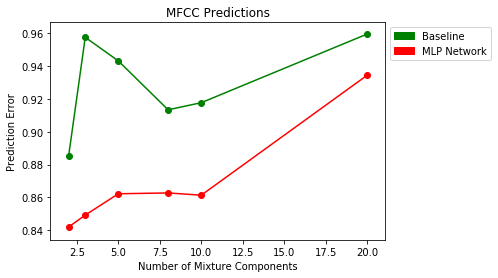

In [288]:
# Compute "True" MFCC error on dev data
baseline_errors_per_dataset = []
mlp_errors_per_dataset = []

for m in mixture_values:
    source_energies = copy.deepcopy(dev_energies)
    dev_mix_mfccs = dev_mixture_datasets[m]['mix_mfccs']
    #baseline_predictions = make_baseline_predictions(dev_mix_mfccs, dev_mixture_datasets[m]['components'])
    baseline_predictions = make_baseline_predictions(dev_weighted_mfccs, dev_mixture_datasets[m]['components'], energy_list=source_energies) 
    dev_mixture_datasets[m]['baseline_predicted_mix_mfccs'] = baseline_predictions
    #baseline_errors = get_errors(dev_mix_mfccs, baseline_predictions)
    baseline_errors = get_relative_errors(dev_mix_mfccs, baseline_predictions, dev_mixture_datasets[m]['mean_mfcc'])
    baseline_errors_per_dataset.append(baseline_errors)

    X_dev = get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs)
    mlp_predictions = mlp_models[m].predict(X_dev, batch_size=200)    
    #mlp_errors = get_errors(dev_mix_mfccs, mlp_predictions)
    mlp_errors = get_relative_errors(dev_mix_mfccs, mlp_predictions, dev_mixture_datasets[m]['mean_mfcc'])
    mlp_errors_per_dataset.append(mlp_errors)
    
    print("Mean Baseline Error: ", np.mean(baseline_errors), " | Mean MLP Error: ", np.mean(mlp_errors))
    
plt.title("MFCC Predictions")
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error")

_ = plt.plot(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'g')
_ = plt.scatter(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'g')

_ = plt.plot(mixture_values, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(mixture_values, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

handles = [mpatches.Patch(color='g',label='Baseline'),
           mpatches.Patch(color='r',label='MLP Network')]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

In [192]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [533]:
preds_20 = np.array(dev_mixture_datasets[20]['baseline_predicted_mix_mfccs'])
true_20 = np.array(dev_mixture_datasets[20]['mix_mfccs'])

preds_2 = np.array(dev_mixture_datasets[2]['baseline_predicted_mix_mfccs'])
true_2 = np.array(dev_mixture_datasets[2]['mix_mfccs'])

In [572]:
#np.std(true_20, axis=0)
#np.std(preds_20, axis=0)
#np.std(true_2, axis=0)
#np.std(preds_2, axis=0)

In [561]:
import matplotlib.patches as mpatches

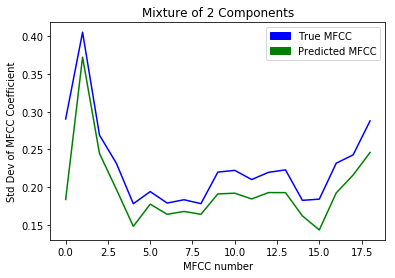

In [564]:
plt.title("Mixture of 2 Components")
plt.xlabel("MFCC number")
plt.ylabel("Std Dev of MFCC Coefficient")
plt.plot(np.std(true_2, axis=0), c='b')
_ = plt.plot(np.std(preds_2, axis=0), c='g')

handles = [mpatches.Patch(color='b',label='True MFCC'),mpatches.Patch(color='g',label='Predicted MFCC')] #for i, t in enumerate(list(set(descriptor_list)))]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

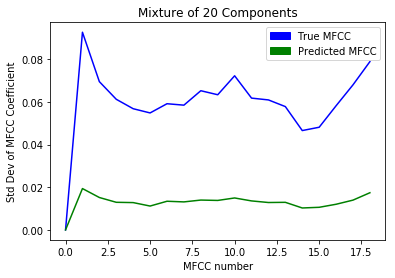

In [565]:
plt.title("Mixture of 20 Components")
plt.xlabel("MFCC number")
plt.ylabel("Std Dev of MFCC Coefficient")
plt.plot(np.std(true_20, axis=0), c='b')
plt.plot(np.std(preds_20, axis=0), c='g')

handles = [mpatches.Patch(color='b',label='True MFCC'),mpatches.Patch(color='g',label='Predicted MFCC')] #for i, t in enumerate(list(set(descriptor_list)))]
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

In [511]:
from sklearn.metrics import mean_squared_error

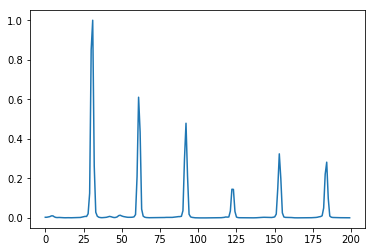

In [341]:
plt.plot(train_weighted_ffts[186][0:200])

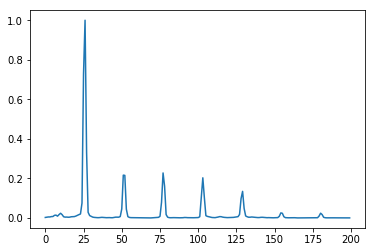

In [343]:
plt.plot(train_weighted_ffts[421][0:200])

<h3> Experiments with Autoencoders </h3>

In [20]:
all_mean_mfcc = []
for i in tqdm(range(len(all_wav_files))):
    y, sr = librosa.load(all_wav_files[i], duration=max_duration)
    all_mean_mfcc.append(np.mean(librosa.feature.mfcc(y, n_mfcc=13), axis=1))

100%|██████████| 1532/1532 [02:19<00:00, 10.99it/s]


In [434]:
mfcc_data = [m[1:] for m in all_mean_mfcc]

In [275]:
all_mfcc = []
for i in tqdm(range(len(all_wav_files))):
    y, sr = librosa.load(all_wav_files[i], duration=max_duration)
    all_mfcc.append(librosa.feature.mfcc(y, n_mfcc=13))

100%|██████████| 1532/1532 [04:15<00:00,  5.04it/s]


In [438]:
good_indices = []
for i, m in enumerate(all_mfcc):
    if m.shape==(13, 87):
        good_indices.append(i)

In [440]:
full_mfcc_data = [m[1:,:].reshape(-1) for m in all_mfcc if m.shape==(13, 87)] #exclude ones that were shorter than 2 seconds

In [441]:
mfcc_data = [m for i, m in enumerate(mfcc_data) if i in good_indices]

In [442]:
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
import keras.optimizers

In [311]:
def initialize_autoencoder():
    model = Sequential()
    model.add(Dense(100, use_bias=True,input_dim=12*87))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(12, use_bias=True))
    model.add(keras.layers.BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(100, use_bias=True))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(12*87, use_bias=True))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])
    return model 

In [483]:
train = np.array(full_mfcc_data[0:1000])
dev = np.array(full_mfcc_data[1000:])

In [318]:
model = initialize_autoencoder()
model.fit(np.array(train), np.array(train), validation_data=(dev,dev), epochs=50)
model.evaluate(np.array(train), np.array(train))

In [484]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
dev = scaler.transform(dev)

In [487]:
dev.shape

(495, 1044)

In [523]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras.losses import mse

original_dim = 12*87
batch_size = 5
intermediate_dim = 100
latent_dim=50

# VAE model = encoder + decoder
# build encoder model

inputs = Input(batch_shape=(batch_size, original_dim))
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dropout(rate=0.5)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(rate=0.5)(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.Adam()
vae.compile(optimizer=optimizer)

/home/jrgillick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


In [528]:
for e in range(10):
    vae.fit(train, batch_size=5)
    print(vae.evaluate(dev, batch_size=5))

Epoch 1/1
495/495 [==============================] - 0s 461us/step
686.9288064975931
Epoch 1/1
495/495 [==============================] - 0s 538us/step
674.4179724491004
Epoch 1/1
495/495 [==============================] - 0s 578us/step
683.6457510283499
Epoch 1/1
495/495 [==============================] - 0s 567us/step
693.5525506530145
Epoch 1/1
495/495 [==============================] - 0s 561us/step
678.7203156442354
Epoch 1/1
495/495 [==============================] - 0s 569us/step
680.6198650321575
Epoch 1/1
495/495 [==============================] - 0s 505us/step
682.0862722685843
Epoch 1/1
495/495 [==============================] - 0s 575us/step
679.473589656329
Epoch 1/1
495/495 [==============================] - 0s 553us/step
674.7114128343986
Epoch 1/1
495/495 [==============================] - 0s 465us/step
690.9737986555003


In [531]:
scaled_mfcc_data = np.vstack([train,dev])

In [545]:
mfcc_encodings=np.array(encoder.predict(np.array(scaled_mfcc_data), batch_size=5))[0,:,:]
mfcc_encodings = list(np.array(mfcc_encodings).squeeze())

In [546]:
#mfcc_encodings = [encoder.predict(np.array(scaled_mfcc_data[i:i+1]))[0] for i in tqdm(range(len(scaled_mfcc_data)))]
#mfcc_encodings = list(np.array(mfcc_encodings).squeeze())

<h3> Some Visualizations with PCA/TSNE </h3>

In [547]:
instrument_types = [get_instrument_type(f) for i, f in enumerate(all_wav_files) if i in good_indices]
instruments = [get_instrument(f) for i, f in enumerate(all_wav_files) if i in good_indices]
pitch_classes = [get_pitch_class(f) for i, f in enumerate(all_wav_files) if i in good_indices]
octaves = [get_octave(f) for i, f in enumerate(all_wav_files) if i in good_indices]

n_instrument_types = len(set(instrument_types))
n_instruments = len(set(instruments))
n_pitch_classes = len(set(pitch_classes))
n_octaves = len(set(octaves))

print("Instrument types: ", n_instrument_types)
print("Instruments: ", n_instruments)
print("Pitch Classes: ", n_pitch_classes)
print("Octaves: ", n_octaves)

Instrument types:  3
Instruments:  12
Pitch Classes:  7
Octaves:  8


In [548]:
np.array(mfcc_encodings).shape

(1495, 50)

In [549]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

pca = PCA(n_components=2)
pca_result = pca.fit_transform(mfcc_data)
pca_result_vae = pca.fit_transform(mfcc_encodings)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_result = tsne.fit_transform(mfcc_data)
tsne_result_vae = tsne.fit_transform(mfcc_encodings)

df = pd.DataFrame({'mfcc': mfcc_data,
                   'instrument_type': instrument_types,
                   'instrument': instruments,
                   'pitch_class': pitch_classes,
                   'octave': octaves,
                   'pca_1': list(pca_result[:,0]),
                   'pca_2': list(pca_result[:,1]), #'pca_3': list(pca_result[:,2]),
                   'tsne_1': list(tsne_result[:,0]),
                   'tsne_2': list(tsne_result[:,1]), #'tsne_3': list(tsne_result[:,2]),
                   'pca_vae_1': list(pca_result_vae[:,0]),
                   'pca_vae_2': list(pca_result_vae[:,1]), #'pca_vae_3': list(pca_result_vae[:,2]),
                   'tsne_vae_1': list(tsne_result_vae[:,0]),
                   'tsne_vae_2': list(tsne_result_vae[:,1]), #'tsne_vae_3': list(tsne_result_vae[:,2]),                   
                  })

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1495 samples in 0.002s...
[t-SNE] Computed neighbors for 1495 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1495
[t-SNE] Computed conditional probabilities for sample 1495 / 1495
[t-SNE] Mean sigma: 11.315801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.286293
[t-SNE] KL divergence after 3000 iterations: 0.612893
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1495 samples in 0.002s...
[t-SNE] Computed neighbors for 1495 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1495
[t-SNE] Computed conditional probabilities for sample 1495 / 1495
[t-SNE] Mean sigma: 1.697508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.556290
[t-SNE] KL divergence after 3000 iterations: 0.604791


In [550]:
from mpl_toolkits.mplot3d import Axes3D

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','b', 'g', 'r', 'c', 'm', 'y', 'k']

# d can be 'instrument_type', 'instrument', 'pitch_class', 'octave', etc.
def plot_by_descriptor(descriptor_list, descriptor_name, plot_type='pca', dims=2):
    if dims==3:
        fig = plt.figure(figsize=(8,8),dpi=80)
        ax = fig.add_subplot(111, projection='3d')
    for i, name in enumerate(list(set(descriptor_list))):
        data = df[df[descriptor_name]==name]
        if plot_type=='pca':
            if dims==3:
                #ax.scatter(data.pca_1, data.pca_2, data.pca_3, c=colors[i])
                ax.scatter(data.pca_vae_1, data.pca_vae_2, data.pca_3, c=colors[i])
            else:
                plt.scatter(data.pca_1, data.pca_2, c=colors[i])
        elif plot_type=='tsne':
            if dims==3:
                #ax.scatter(data.tsne_1, data.tsne_2, data.tsne_3, c=colors[i])
                ax.scatter(data.tsne_vae_1, data.tsne_vae_2, data.tsne_3, c=colors[i])
            else:
                plt.scatter(data.tsne_vae_1, data.tsne_vae_2, c=colors[i])
    
    handles = [mpatches.Patch(color=colors[i],label=t) for i, t in enumerate(list(set(descriptor_list)))]
    plt.legend(bbox_to_anchor=(1, 1),handles=handles)
    plt.show()

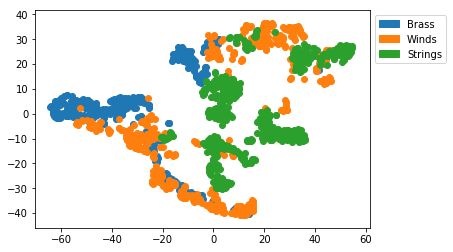

In [551]:
plot_by_descriptor(instrument_types, 'instrument_type', plot_type='tsne', dims=2)

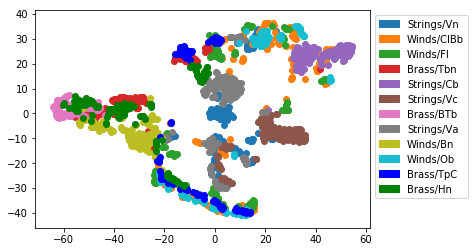

In [555]:
plot_by_descriptor(instruments, 'instrument', plot_type='tsne', dims=2)

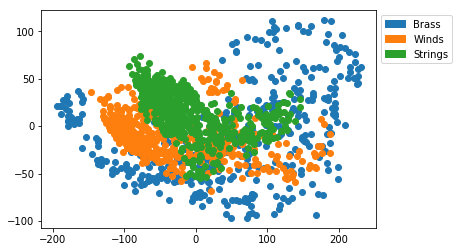

In [554]:
plot_by_descriptor(instrument_types, 'instrument_type', plot_type='pca', dims=2)